# Some first comments and info 

Different data queries have been done, including: 
- Different time frames (1/3/6/12 months)
- Different features' sets 
- Hour and Minute information 

With the information extracted from those queries, it was concluded that: 
- We will work with 12 months worth of data (a whole year). Working with 2 years worth of data (2020-2021) is not possible because Google Analytics "just" stores the cookies (clientID) data for a period of 2 years. This period can get extended for another 2 years every time that a clientID visit the website again. However, we cannot just assume that all visitors will visit a website for a second time in a 2 year period. Therefore, just one year was selected. Other features (like age, gender) are deleted after 6 months (not sure where I read this, check!)
- Also, this is an observation study - in other words, we did not set any kind of special promotion or advertisement and just observed the data that already existed. This brings challenges like 
    - Working with data from periods that have been considerably good/better for donations ("Covid times"). Not sure if official references exist in this regard 
    - Working with data that includes "special" days for donations, like #GivingTuesday 
    - Working with data from external and also internal (already donors) users. Internal users tend to react better (i.e. they react to emails)
    - Some visits to the website are done to the Karriere Portal 
- We will import a basic feature set. Some other features exist as well and may be imported and integrated in the analysis, if needed 
- Importing not just the date, but also hour + minute of the visit created a big redundancy in the dataset. The reason was that pagevisits (and maybe other related features like hits, events, etc) are shown per minute. On the other hand, the total time spent in website in one session is just shown on the first row for a clientID. We decided to import date + hour, just to extract "time of start" of the website visit. The original idea was taking into account those visitors with several visits on the same day and through the same channel, but I think building up such table is too complex for the (probably) limited number of cases that will exist. 

# Part I. EDA 


## Getting data from Supermetrics



Follow tutorial https://supermetrics.com/blog/how-to-load-data-into-mysql

Urls are stored in 'constants_MT.py', which will not be pushed into the repo. Urls contain the supermetrics queries for different timeframes in 2021. At first, just some basic features are imported, including clientID, transaction yes/no and transaction amount. Since tables from supermetric queries have a maximum size of 1.000.000 rows, two tables may be needed (depending on the query)

After some trials with different time frames, I finally decided to work with 12 months (01.01.2021 - 31.12.2021)

Steps to import data from supermetrics: 

* Import urls from constant file
* Call API 
* Check response - response needs to be 200 to be successfull; 500 indicates error

In [1]:
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn 
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module. See https://stackoverflow.com/questions/33323707/how-do-i-reload-a-module-after-changing-it 
import statistics 

In [2]:
# import basic table containing time data 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_june
response_basic_june = requests.get(url_12months_complete_time_til_june)
print(response_basic_june)

# importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_dec
response_basic_dec = requests.get(url_12months_complete_time_til_dec)
print(response_basic_dec)


<Response [200]>
<Response [200]>


### Create table from url data 

* Define function 
* Apply to different URLs
* Merge tables of extended datasets 
* Check available features

In [3]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [4]:
df_basic1 = url_to_df(url_12months_complete_time_til_june, response_basic_june)
df_basic2 = url_to_df(url_12months_complete_time_til_dec, response_basic_dec)

# concatenate tables 
frames = [df_basic1, df_basic2]
df_basic = pd.concat(frames)

As we can see, some pretreatment is needed

In [5]:
# select table to work with 
df = df_basic
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015525 entries, 0 to 452058
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   clientID             1015525 non-null  object
 1   Date                 1015525 non-null  object
 2   Hour                 1015525 non-null  object
 3   Minute               1015525 non-null  object
 4   Source               1015525 non-null  object
 5   Medium               1015525 non-null  object
 6   Channel group        1015525 non-null  object
 7   Operating system     1015525 non-null  object
 8   Users                1015525 non-null  object
 9   Transactions         1015525 non-null  object
 10  Transaction revenue  1015525 non-null  object
 11  Pageviews            1015525 non-null  object
 12  Total time on site   1015525 non-null  object
dtypes: object(13)
memory usage: 108.5+ MB


## Data pretreatment



### Data pretreatment for EDA 

* Create time feature combining hour + minute
* Drop redundant features 
* Transform data into correct format 
* Reorder columns and table using clientID, Date and Time 
* Extract time of start and time of end of visit and drop redundancy in dataset (start and end time are features and as such do not create row-redundancy). They will have an effect on path_order
* Create features: path_order, new_old_client_in_2021

In [6]:
# combine hour + minute 
df['Time'] = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)

# drop redundant features 
df.drop('Hour', axis = 1, inplace = True)
df.drop('Minute', axis = 1, inplace = True)

In [7]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f in ['Date', 'Time']:
            df[f] = pd.to_datetime(df[f])
        #elif f == 'Time': 
        #    df[f] = pd.to_datetime(df[f], format='%H:%M:%S')
        else: # all numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

In [8]:
feats_to_convert = ['Date', 'Transactions', 'Transaction revenue', 'Pageviews', 'Total time on site', 'Users']
df = transform_class(df, feats_to_convert)

In [9]:
# reorder columns 
df = df[['clientID', 'Date', 'Time', 'Transactions', 'Transaction revenue', 'Channel group', 'Operating system', 'Source', 'Medium', 'Total time on site', 'Pageviews', 'Users']]

# reorder table by clientID, Date and Time 
df = df.sort_values(['clientID', 'Date', 'Time'])

# check number of unique clientIDs 
# print('Number of unique visitor identifiers: ', df['clientID'].nunique())

In [10]:
# extract information about first time with total time on site (which can be found on first row) + last time + rename columns 
df_firsttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].first()
df_firsttime.rename(columns = {'Time':'time_start'}, inplace = True)
df_lasttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].last()
df_lasttime.rename(columns = {'Time':'time_end'}, inplace = True)

In [11]:
# 'outer' keeps both, merge on all feats to avoid redundancy in merged dataset 
df_first_and_last = pd.merge(left = df_firsttime, right = df_lasttime, how = 'outer', on = ['clientID', 'Date', 'Channel group'])
df_first_and_last = df_first_and_last.drop_duplicates() # those where Time (First) and time (last) are the same 
df_first_and_last.head()

,clientID,Date,Channel group,time_start,time_end
0,1000005671.1568444004,2021-01-04,Display,22:30:00,22:30:00
1,1000006728.1622927843,2021-06-05,Direct,23:17:00,23:17:00
2,1000020259.1556972396,2021-01-31,Referral,19:57:00,19:57:00
3,1000023369.1635190743,2021-10-25,Referral,21:39:00,21:39:00
4,1000024791.1630470945,2021-09-01,Branded Paid Search,06:35:00,06:36:00


In [12]:
# transform date + time into timestamp. Takes a while 
df_first_and_last['timestamp_start'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_start.apply(str))
df_first_and_last['timestamp_end'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_end.apply(str))

# calculate difference between both timestamps - in minutes
df_first_and_last['timestamp_diff'] = (df_first_and_last['timestamp_end'] - df_first_and_last['timestamp_start']).astype('timedelta64[m]')

In [13]:
# re-calculate total time on site and pageviews - sum per clientID and date 
df_first_and_last

,clientID,Date,Channel group,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff
0,1000005671.1568444004,2021-01-04,Display,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0
1,1000006728.1622927843,2021-06-05,Direct,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0
2,1000020259.1556972396,2021-01-31,Referral,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0
3,1000023369.1635190743,2021-10-25,Referral,21:39:00,21:39:00,2021-10-25 21:39:00,2021-10-25 21:39:00,0.0
4,1000024791.1630470945,2021-09-01,Branded Paid Search,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0
...,...,...,...,...,...,...,...,...
467212,999973068.1611254848,2021-01-21,Display,19:45:00,19:45:00,2021-01-21 19:45:00,2021-01-21 19:45:00,0.0
467213,99997309.1608586309,2021-01-04,Display,16:48:00,16:48:00,2021-01-04 16:48:00,2021-01-04 16:48:00,0.0
467214,999988377.1636720143,2021-11-12,Display,13:29:00,13:29:00,2021-11-12 13:29:00,2021-11-12 13:29:00,0.0
467215,999996741.1623865085,2021-06-16,(Other),19:38:00,19:38:00,2021-06-16 19:38:00,2021-06-16 19:38:00,0.0


In [14]:
new_df = df 
new_df = new_df.groupby(['clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium']).sum()
new_df = new_df.reset_index()

# merge with original dataset, keeping rows from df_first_and_last 
df_final = pd.merge(left = new_df, right = df_first_and_last, how = 'left', on = ['clientID', 'Date', 'Channel group'])
# df_final 

In [15]:
# create path order per clientID and date 
df_final['path_order'] = df_final.groupby('clientID').cumcount() + 1
df_final['path_order_by_date'] = df_final.groupby(['clientID', 'Date']).cumcount() + 1

In [16]:
# create feature of new/old client in 2021
## new => path_order = 1
## old => path_order > 1
df_final['type_of_client_by_path_order'] = (df_final.path_order > 1).astype('int')
# change categories 
df_final.type_of_client_by_path_order[df_final.type_of_client_by_path_order == 1] = 'old_by_path_order'
df_final.type_of_client_by_path_order[df_final.type_of_client_by_path_order == 0] = 'new_by_path_order'

# check result 
# df_final.value_counts(['path_order', 'type_of_client_by_path_order'])

C:\Users\carol\AppData\Local\Temp\ipykernel_5576\1204769777.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.type_of_client_by_path_order[df_final.type_of_client_by_path_order == 1] = 'old_by_path_order'


In [17]:
df_final[df_final['path_order'] > 1]
# check specific case 
df_final[df_final['clientID'] == '1000102684.1614848502']

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order
20,1000102684.1614848502,2021-03-04,Generic Paid Search,Windows,google,cpc,0,0.0,8,1,1,10:01:00,10:01:00,2021-03-04 10:01:00,2021-03-04 10:01:00,0.0,1,1,new_by_path_order
21,1000102684.1614848502,2021-12-21,Display,Windows,google,cpc,0,0.0,0,1,1,15:29:00,15:29:00,2021-12-21 15:29:00,2021-12-21 15:29:00,0.0,2,1,old_by_path_order


`new_old_client` contains one row per clientID, indicating if clientID appears once ("new_in_2021") or more often ("old_in_2021") in the dataset

In [18]:
# create feature of new/old client - grouping information + merge with original dataset 
new_old_client = df_final[['clientID', 'Date', 'path_order']]
new_old_client = new_old_client.sort_values(['clientID', 'path_order'])
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['general_type_of_client'] = (new_old_client.path_order > 1).astype('int')
# change name of categories 
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 0] = 'new_in_2021'

# drop features not needed - all except clientID and general_type_of_client 
new_old_client.drop(['Date', 'path_order'], axis = 1, inplace = True)
# new_old_client

C:\Users\carol\AppData\Local\Temp\ipykernel_5576\3753712506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'


In [19]:
# merge with original table using clientID to have new_old_client feature available 
df_eda = pd.merge(df_final, new_old_client, how = 'left', on = ('clientID'))
df_eda.head()

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,1,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,1,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,1,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021
3,1000023369.1635190743,2021-10-25,Referral,Android,sos-kinderdorf.bewerberportal.at,referral,0,0.0,0,1,1,21:39:00,21:39:00,2021-10-25 21:39:00,2021-10-25 21:39:00,0.0,1,1,new_by_path_order,new_in_2021
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,2,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021


In [20]:
# check and drop missing data 
print(df_eda.isna().sum()) # no missing data 
df_eda = df_eda.dropna()

0
clientID                        0
Date                            0
Channel group                   0
Operating system                0
Source                          0
Medium                          0
Transactions                    0
Transaction revenue             0
Total time on site              0
Pageviews                       0
Users                           0
time_start                      0
time_end                        0
timestamp_start                 0
timestamp_end                   0
timestamp_diff                  0
path_order                      0
path_order_by_date              0
type_of_client_by_path_order    0
general_type_of_client          0
dtype: int64


We got to realise that some visits were done through a Bewerberportal (source). We checked if some transactions were also done: 
* No transaction for one-time visit 
* 0.18% of transactions for the more-times visit 

We decided therefore to drop those visitors 

In [21]:
# grouped df per client - to extract one vs more visits 
grouped_df_per_clientID = df_eda[['clientID']].groupby('clientID').value_counts()
grouped_df_per_clientID = grouped_df_per_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
grouped_df_per_clientID['one_vs_more_times_visitor'] = np.where(grouped_df_per_clientID > 1, "more_times", "once")
grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts()

once          277980
more_times     63833
Name: one_vs_more_times_visitor, dtype: int64

In [22]:
# extract usrs with just one visit
users_one_visit = grouped_df_per_clientID[grouped_df_per_clientID['one_vs_more_times_visitor'] == 'once']
users_one_visit.index.name = 'clientID'
users_one_visit.reset_index(inplace=True)

# extract users with more than one visit 
users_more_visits = grouped_df_per_clientID[grouped_df_per_clientID['one_vs_more_times_visitor'] == 'more_times']
users_more_visits.index.name = 'clientID'
users_more_visits.reset_index(inplace=True)

df_one_visit = df_eda[df_eda['clientID'].isin(users_one_visit['clientID'])]
df_more_visits = df_eda[df_eda['clientID'].isin(users_more_visits['clientID'])]


In [23]:
#special case: source sos-kinderdorf.bewerberportal.at'
print('Number of visitors to Bewerberportal with one visit: ', len(df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at']))
print('Transactions from Bewerber in one-time visitor: ', df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at'].Transactions.sum()) #0
print('Number of visitors to Bewerberportal with more than one visit: ', len(df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at']))
print('Transactions from Bewerber in more-times visitor: ', df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at'].Transactions.sum()) # 20

Number of visitors to Bewerberportal with one visit:  1354
Transactions from Bewerber in one-time visitor:  0
Number of visitors to Bewerberportal with more than one visit:  10630
Transactions from Bewerber in more-times visitor:  20


In [24]:
# drop those website visitors 
karriere1 = df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
karriere2 = df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
print('Number of unique visitors to career site, with one visit: ', karriere1.nunique())
print('Number of unique visitors to the career site, with more than one visit: ', karriere2.nunique())

Number of unique visitors to career site, with one visit:  1354
Number of unique visitors to the career site, with more than one visit:  7496


In [25]:
df_eda = df_eda[-df_eda['clientID'].isin(karriere1)]
df_eda = df_eda[-df_eda['clientID'].isin(karriere2)]
print(len(df_eda))

435840


#### Create table of grouped values 

* Grouped values of numeric features
* Add columns of number of unique and total client IDs (per day). This has to be calculated separated (cannot be calculated using "Users", because redundancy exists)

In [26]:
# create table of grouped df - with numeric values grouped by date 
df_grouped = df_eda[['Date', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_date = df_grouped.groupby(['Date']).sum() 
# add column of unique clientID count 
df_grouped_by_date['number_unique_clientID'] = df.groupby('Date')['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_date['number_total_clientID'] = df.groupby('Date').size().values
df_grouped_by_date

,Transactions,Transaction revenue,Total time on site,Pageviews,number_unique_clientID,number_total_clientID
Date,,,,,,
2021-01-01,41,5864.90,414794,7847,4653,9230
2021-01-02,47,25287.00,470093,8553,4834,9995
2021-01-03,31,4047.40,433822,8847,5247,10058
2021-01-04,37,6637.00,443755,9443,5223,10213
2021-01-05,26,2845.21,500315,8524,4823,10139
...,...,...,...,...,...,...
2021-12-27,66,15560.00,175372,4621,2173,4357
2021-12-28,67,13280.00,160972,4464,2026,4130
2021-12-29,69,13842.00,151758,4039,1736,3731


#### Create table of channel + grouped features

In [27]:
# create table of channel + group by channel group and date 
df_channel = df_eda[['Date', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
# add column of unique clientID count 
df_grouped_by_channel['number_unique_clientID'] = df_eda.groupby(['Date', 'Channel group'])['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_channel['number_total_clientID'] = df_eda.groupby(['Date', 'Channel group']).size().values
df_grouped_by_channel

0                               Transactions  Transaction revenue  \
Date       Channel group                                            
2021-01-01 (Other)                         0                  0.0   
           Branded Paid Search            16               2475.0   
           Direct                          6                710.0   
           Display                         0                  0.0   
           Email                           1                 75.0   
...                                      ...                  ...   
2021-12-31 Generic Paid Search             0                  0.0   
           Organic Search                 29               4013.0   
           Referral                        0                  0.0   
           Social                          0                  0.0   
           YouTube Ads                     0                  0.0   

0                               Total time on site  Pageviews  \
Date       Channel group                                        
2021-01-01 (Other)                              68          2   
           Branded Paid Search               22802        459   
           Direct                            23242        437   
           Display                          300453       5409   
           Email                               544         21   
...                                            ...        ...   
2021-12-31 Generic Paid Search                1097         40   
           Organic Search                    29980        680   
           Referral                           2814         58   
           Social                              822         69   
           YouTube Ads                          54         10   

0                               number_unique_clientID  number_total_clientID  
Date       Channel group                                                       
2021-01-01 (Other)                                   1                      1  
           Branded Paid Search                     114                    114  
           Direct                                  151                    151  
           Display                                3784                   3784  
           Email                                     7                      7  
...                                                ...                    ...  
2021-12-31 Generic Paid Search                      19                     19  
           Organic Search                          244                    245  
           Referral                                 19                     19  
           Social                                   42                     42  
           YouTube Ads                               8                      8  

[3446 rows x 6 columns]

### Data pretreatment for attribution modelling 

For attribution modelling we need to: 
* Split customer paths into chunks, to represent "path until reaction" - because customers may react more than once, and we are interested on the "path until reaction" 
* Create table of paths with specific structure - necessary to work with attribution modelling package 

In [28]:
# reorder table by clientID, Date and time_start 
df_eda = df_eda.sort_values(['clientID', 'timestamp_start'])
df_eda.head()

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,1,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,1,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,1,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,2,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021
5,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,3,22:38:00,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021


(?) Is there a better way to do it? - with apply or lambda probably, but Im not sure how

In [29]:
# test - apply to part of the dataset with transactions and more than one channel group 
# otherwise the loop takes too long 
df_sub = df_eda[(df_eda['Transactions'] > 0) & (df_eda['path_order'] > 1)]
client_list = df_sub['clientID'].unique()
# client_list


In [30]:
path_counter = []

for client in client_list: 
    #print(client)
    # reset path number 
    path_number = 1
    # extract data 
    client_df = df_eda[df_eda['clientID'] == client]
    #print(client_df)
    if len(client_df) == 1: # nvm if Transaction = 0 or + 
        #print("if")
        # path_number = 1
        path_counter.append(path_number)
    else: # len > 1 
        #print("else")# 
        for i in range(0,len(client_df)): 
            #print("i", i)
            if client_df.iloc[i]['Transactions'] == 0: 
                # keep same path_counter 
                path_number = path_number
                path_counter.append(path_number)
                #print("if", path_counter)
            else: # if transaction exist 
                # keep same path counter but update it afterwards 
                path_counter.append(path_number)
                path_number += 1
                #print("else", path_counter)

In [31]:
# create table sub_df with client_list - clients with transaction + path_order > 1 
sub_df = df_eda[df_eda.clientID.isin(client_list)]
sub_df['path_counter'] = path_counter

# create table sub_df2 with clients without any transaction 
sub_df2 = df_eda[df_eda.clientID.isin(client_list) == False]
sub_df2['path_counter'] = 1

# concatenate both data tables 
df_merge = [sub_df2, sub_df]
df_merge = pd.concat(df_merge) 
# df_model

C:\Users\carol\AppData\Local\Temp\ipykernel_5576\1060449220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['path_counter'] = path_counter
C:\Users\carol\AppData\Local\Temp\ipykernel_5576\1060449220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df2['path_counter'] = 1


In [32]:
# create df of model - grouping by clientID and path_counter 
df_model = df_merge.groupby(['clientID', 'path_counter']).sum().reset_index() #.sum(['Transactions', 'Transaction revenue'])
# df_model

# create df of paths 
df_paths = df_merge.groupby(['clientID', 'path_counter'])['Channel group'].apply(lambda x: ' > '.join(x)).reset_index()
# df_paths 

# add path information to df_model, using clientID and path_counter to join tables 
df_model = pd.merge(left = df_model, right = df_paths, how = 'left', on = ['clientID', 'path_counter'])
df_model

# check results 
# df_model[df_model['path_counter'] > 1]
# df_model[df_model['clientID'] == '980880842.1638283748']

,clientID,path_counter,Transactions,Transaction revenue,Total time on site,Pageviews,Users,timestamp_diff,path_order,path_order_by_date,Channel group
0,1000005671.1568444004,1,0,0.0,0,1,1,0.0,1,1,Display
1,1000006728.1622927843,1,0,0.0,0,1,1,0.0,1,1,Direct
2,1000020259.1556972396,1,0,0.0,0,1,1,0.0,1,1,Referral
3,1000024791.1630470945,1,0,0.0,38,2,2,1.0,1,1,Branded Paid Search
4,1000025674.1610314739,1,0,0.0,0,1,3,2.0,1,1,Organic Search
...,...,...,...,...,...,...,...,...,...,...,...
333705,999973068.1611254848,1,0,0.0,0,1,1,0.0,1,1,Display
333706,99997309.1608586309,1,0,0.0,0,1,1,0.0,1,1,Display
333707,999988377.1636720143,1,0,0.0,0,1,1,0.0,1,1,Display
333708,999996741.1623865085,1,0,0.0,0,1,1,0.0,1,1,(Other)


## Data under study 


* Original imported table contains 1.015.525 entries with 341.813 unique client IDs and 8.072 conversions. 
* Because of its structure, dataset contained redundancy (i.e. each hit/pageview from a session was stored in a new row in the dataset). After some pretreatment, the dataset under study contains 467.920 entries from 341.813 unique clientIDs. New, pretreated dataset also contains some more (extracted) features. 
* No rows with missing data found in the dataset. Some rows with missing data were contained on sociodemographic features on the extended table 
* Visitors to the Bewerberportal filtered - no transaction for the one-time visitors and just 20 transactions (0.2%) for the more-times visitors.
* Data imported include all client IDs, i.e. those with and without transaction. As expected, the dataset is very imbalanced in terms of conversions - just 8.072 conversions for the whole year, which corresponds to 1,72% for the whole visits and 2,36% per unique visitor
* Data corresponds to traffic data in the website of interest, for a period of one year (01.01.2021 - 31.12.2021)

Attention! Number of transactions != number of client IDs with transactions (more than one transaction may exist)
Also, because of the dataset original structure and the pretreatment done, visits on a same day will not appear on the final dataset. 

In [33]:
# check original, general numbers
print('Check results of original table (with redundancy)')
print('Number of rows: ', len(df)) 

Check results of original table (with redundancy)
Number of rows:  1015525


In [34]:
print('Check results of table after preprocessing (without redundancy): ')
print('Number of rows: ', len(df_eda))
print('Number of columns: ', df_eda.shape[1]) 
# print('Column names: ')
# print(df_eda.columns) # columns 
print('Number of unique visitor identifiers: ', df_eda['clientID'].nunique())
print('Number of conversions: ', df_eda['Transactions'].sum())
# print(df_eda.head())

Check results of table after preprocessing (without redundancy): 
Number of rows:  435840
Number of columns:  20
Number of unique visitor identifiers:  332963
Number of conversions:  8022


### Check available features and levels of them 


Available features: 
* `clientID` - user identifier 
* `Date`
* `Source` - source of user (google, facebook, direct, etc)
* `Medium` - type of referrals. Directly related to `Source`
    - `utm_medium` - if manual campaign tracking 
    - `cpc` if google ads 
    - `organic` if users came from a search engine detected by google analytics 
    - `referral ` if referrer is not a search engine 
    - `(none)` (empty) if users came directly to the webpage 
* `Channel group` - where user comes from (referral, branded paid search, generic paid search, organic search)
* `keyword` - if coming from google 
* `User Type` - new/retourning visitor 
* `Operating system`
* `Users` - all 1, but we can use it to count users per day 
* `Transactions, Transaction revenue` - indicate if transaction exists or not + revenue 
* `Region, City, Latitude, Longitude`
* `Pageviews` 
* `Hits` - total number of hits for the view (pageview, custom event, etc)
* `Total time on site` - in seconds 
* `Sessions` - group of user interactions with your website that takes place within a given time frame
* `Bounces` - total number of single page (or single interaction hit) sessions 
* `Total events` - user interactions with the website that cannot be tracked

## Exploratory Descriptive Analysis 


In [35]:
df_original = df_eda 
df_giving_tuesday = df_eda[df_eda['Date'] == '2021-11-30']
# drop giving tuesday from df_eda 
df_eda = df_eda[df_eda['Date'] != '2021-11-30']

In [36]:
avg_original_nunique_clientids = round(df_original['clientID'].nunique()/365, 2)
avg_eda_nunique_clientids = round(df_eda['clientID'].nunique()/365, 2)

### Check visit and transaction patterns

#### General trends and GivingTuesday

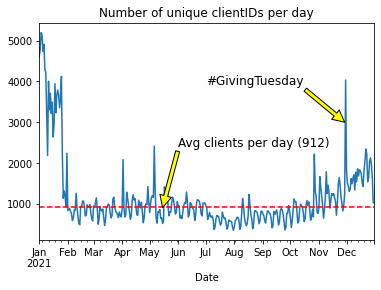

In [37]:
# extract clients per day = sum of unique IDs per day  
df_original.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (912)',
              xy = ('2021-05-15', avg_original_nunique_clientids), 
              xytext =('2021-06-01', avg_original_nunique_clientids + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.annotate('#GivingTuesday', 
             xy = ('2021-11-29', 3000), 
             xytext =('2021-07-01', avg_original_nunique_clientids + 3000), 
             color='black',
             # fontweight='bold',
             fontsize = 12,
             arrowprops = dict(facecolor = 'yellow'))
plt.show()

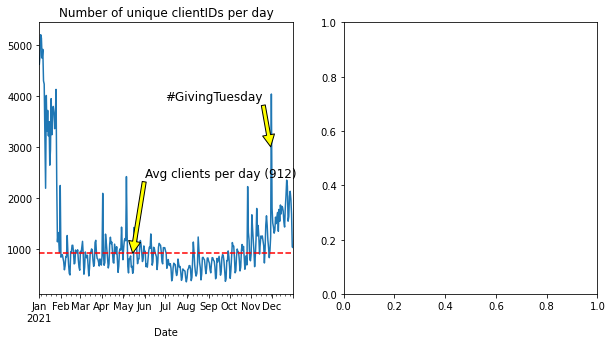

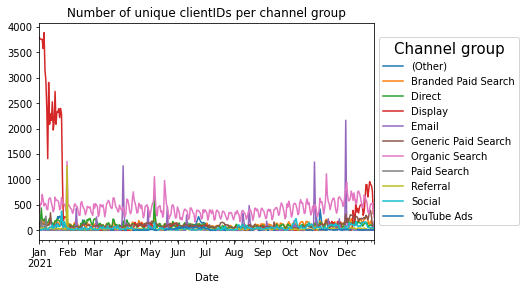

<Figure size 432x288 with 0 Axes>

In [38]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

df_original.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (912)',
              xy = ('2021-05-15', avg_original_nunique_clientids), 
              xytext =('2021-06-01', avg_original_nunique_clientids + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.annotate('#GivingTuesday', 
             xy = ('2021-11-29', 3000), 
             xytext =('2021-07-01', avg_original_nunique_clientids + 3000), 
             color='black',
             # fontweight='bold',
             fontsize = 12,
             arrowprops = dict(facecolor = 'yellow'))

plt.subplot(1, 2, 2) # index 2

df_grouped_by_channel.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

# minimize overlap 
plt.tight_layout()

plt.show()

In [39]:
print('General results')
print('Number of unique clientIDs: ', df_original['clientID'].nunique())
print('Total number of rows (client IDs, new or repeated):', len(df_original))
print('Avg number of unique clientIDs per day:', round(df_original['clientID'].nunique()/365, 2))

General results
Number of unique clientIDs:  332963
Total number of rows (client IDs, new or repeated): 435840
Avg number of unique clientIDs per day: 912.23


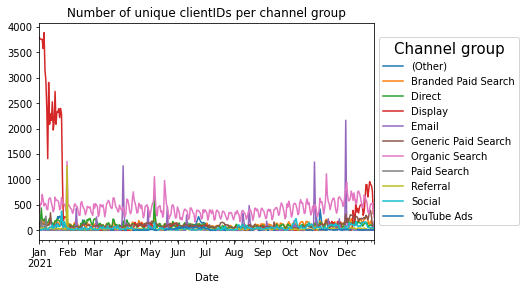

In [40]:
df_grouped_by_channel.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

Text(2021-07-01, 1000, '#GivingTuesday')

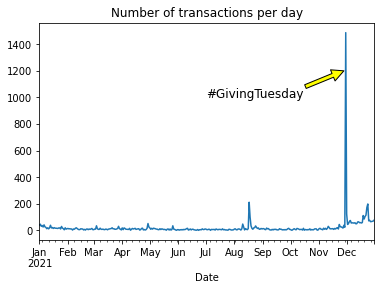

In [41]:
# check transactions per day 
df_original.groupby('Date')['Transactions'].sum().plot()
plt.title("Number of transactions per day")
# add annotation of #givingtuesday 
plt.annotate('#GivingTuesday',
              xy = ('2021-11-28', 1200), 
              xytext =('2021-07-01',1000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))

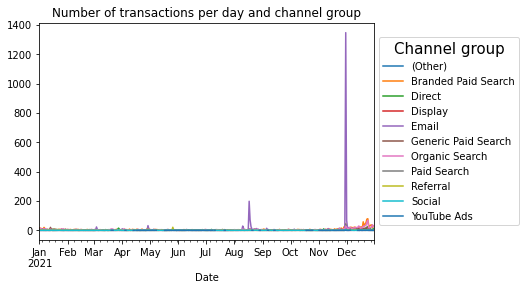

In [42]:
df_grouped_by_channel.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of transactions per day and channel group')
plt.show()

In [43]:
df_transactions = df_original[df_original['Transactions'] > 0]
df_transactions_over1 = df_transactions[df_transactions['Transactions'] > 1]
total_number_transactions = df_transactions['Transactions'].sum()
total_number_transactions_over1 = df_transactions_over1['Transactions'].sum() 

print('Total number of transactions: ', total_number_transactions)
print('Avg number of transactions per day:', round(total_number_transactions/365, 2))
print('Total number of clientIDs with transactions:', len(df_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_transactions_over1.clientID.value_counts()))
print('Total conversion rate: ', round(total_number_transactions / len(df_original)*100), '%')
print('Total value of conversions: ', df_original['Transaction revenue'].sum(), '€')
print('Average transaction value: ', round(df_original['Transaction revenue'].sum() / total_number_transactions), '€')
print('Median transaction value: ', statistics.median(df_transactions['Transaction revenue']))
print('Max. transaction value: ', df_original['Transaction revenue'].max(), '€')
print('Min. transaction value: ', df_original[df_original['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Total number of transactions:  8022
Avg number of transactions per day: 21.98
Total number of clientIDs with transactions: 6951
Total number of clientIDs with more than 1 transaction: 401
Total conversion rate:  2 %
Total value of conversions:  1205195.9200000002 €
Average transaction value:  150 €
Median transaction value:  75.0
Max. transaction value:  60210.0 €
Min. transaction value:  1.0 €


In [47]:
# check results of givingtuesday 
df_giving_tuesday = df_original[df_original['Date'] == '2021-11-30']
transactions_on_giving_tuesday = df_giving_tuesday['Transactions'].sum()
transactions_on_giving_tuesday

print('Average transaction value on GivingTuesday: ', round(df_giving_tuesday['Transaction revenue'].sum() / transactions_on_giving_tuesday), '€')
print('Median transaction value on GivingTuesday: ', statistics.median(df_giving_tuesday[df_giving_tuesday['Transaction revenue'] > 0]['Transaction revenue']), '€')
print('Max. transaction value on GivingTuesday: ', df_giving_tuesday['Transaction revenue'].max(), '€')
print('Min. transaction value on GivingTuesday: ', df_giving_tuesday[df_giving_tuesday['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Average transaction value on GivingTuesday:  86 €
Median transaction value on GivingTuesday:  50.0 €
Max. transaction value on GivingTuesday:  3000.0 €
Min. transaction value on GivingTuesday:  7.5 €


Because of the results obtained, we decided to **filter the data of GivingTuesday** from the dataset. Average of unique users (clientID) remain almost the same. 

In [48]:
print(avg_original_nunique_clientids)
print(avg_eda_nunique_clientids)

912.23
903.85


#### General trends without GivingTuesday

`df_eda`

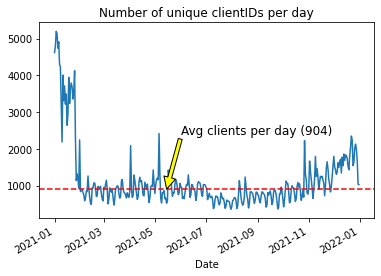

In [49]:
# extract clients per day = sum of unique IDs per day  
## df_eda does not contain data about #GivingTuesday
df_eda.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = avg_eda_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (904)',
              xy = ('2021-05-15', avg_eda_nunique_clientids), 
              xytext =('2021-06-01', avg_eda_nunique_clientids + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [50]:
# create table of channel + group by channel group and date, using filtered data 
df_channel = df_eda[['Date', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_eda_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
# add column of unique clientID count 
df_eda_grouped_by_channel['number_unique_clientID'] = df_eda.groupby(['Date', 'Channel group'])['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_eda_grouped_by_channel['number_total_clientID'] = df_eda.groupby(['Date', 'Channel group']).size().values
df_eda_grouped_by_channel

0                               Transactions  Transaction revenue  \
Date       Channel group                                            
2021-01-01 (Other)                         0                  0.0   
           Branded Paid Search            16               2475.0   
           Direct                          6                710.0   
           Display                         0                  0.0   
           Email                           1                 75.0   
...                                      ...                  ...   
2021-12-31 Generic Paid Search             0                  0.0   
           Organic Search                 29               4013.0   
           Referral                        0                  0.0   
           Social                          0                  0.0   
           YouTube Ads                     0                  0.0   

0                               Total time on site  Pageviews  \
Date       Channel group                                        
2021-01-01 (Other)                              68          2   
           Branded Paid Search               22802        459   
           Direct                            23242        437   
           Display                          300453       5409   
           Email                               544         21   
...                                            ...        ...   
2021-12-31 Generic Paid Search                1097         40   
           Organic Search                    29980        680   
           Referral                           2814         58   
           Social                              822         69   
           YouTube Ads                          54         10   

0                               number_unique_clientID  number_total_clientID  
Date       Channel group                                                       
2021-01-01 (Other)                                   1                      1  
           Branded Paid Search                     114                    114  
           Direct                                  151                    151  
           Display                                3784                   3784  
           Email                                     7                      7  
...                                                ...                    ...  
2021-12-31 Generic Paid Search                      19                     19  
           Organic Search                          244                    245  
           Referral                                 19                     19  
           Social                                   42                     42  
           YouTube Ads                               8                      8  

[3436 rows x 6 columns]

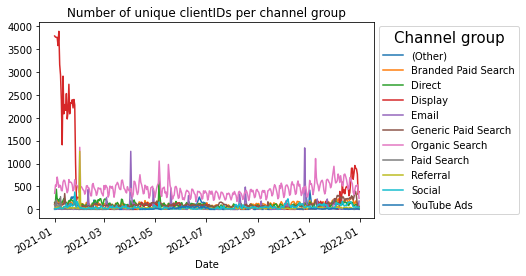

In [51]:
df_eda_grouped_by_channel.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

In [1]:
df_no_giving_tuesday_grouped = df_eda.groupby(['Date'])['Transactions'].sum()
df_no_giving_tuesday_grouped

NameError: name 'df_eda' is not defined

Text(0.5, 1.0, 'Number of transactions per day')

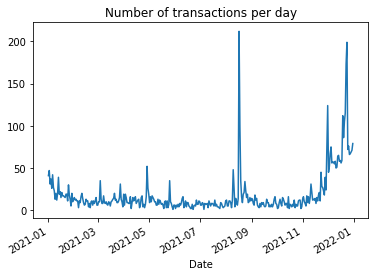

In [132]:
# check transactions per day 

avg_number_transactions_no_giving_tuesday = df_no_gi
df_no_giving_tuesday_grouped.plot()
plt.axhline(y = avg, color = 'r', linestyle = '--')
plt.title("Sum of transactions per day, without #GivingTuesday")
# Annotation
plt.annotate('Avg transactions per day',
              xy = ('2021-02-01', avg_number_transactions_no_giving_tuesday), 
              xytext =('2021-02-15', avg_number_transactions_no_giving_tuesday + 50), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [ ]:
df_channel = df_eda[['Date', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_eda_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
# add column of unique clientID count 
df_eda_grouped_by_channel['number_unique_clientID'] = df_eda.groupby(['Date', 'Channel group'])['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_eda_grouped_by_channel['number_total_clientID'] = df_eda.groupby(['Date', 'Channel group']).size().values
# df_eda_grouped_by_channel

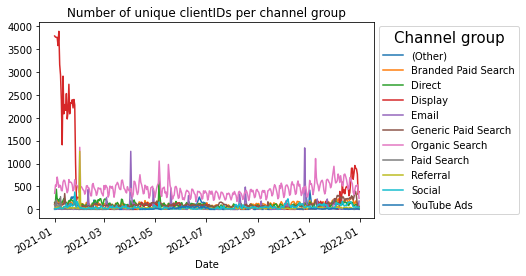

In [134]:
# channel group vs transactions - it does not help much 
df_eda_grouped_by_channel.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

In [ ]:
# plot each channel group into a different plot 
# reset_index() transform grouped table into normal table (with repeated Date)
df_grouped_by_channel2 = df_grouped_by_channel.reset_index()
grid = seaborn.FacetGrid(df_grouped_by_channel2, col = 'Channel group', col_wrap = 3)
grid.map(seaborn.lineplot, 'Date', 'Users')

#### One vs more-times visitor

once          277980
more_times     63833
Name: one_vs_more_times_visitor, dtype: int64


Text(0.5, 1.0, 'Visitors: once vs more frequent visitor in 2021')

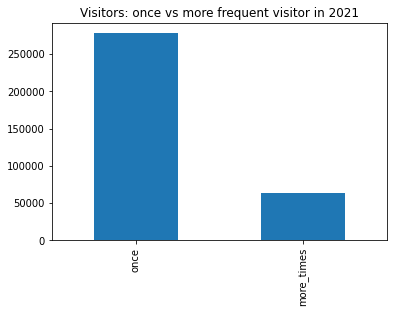

In [91]:
# df grouped per client ID - already done
# plot of new vs old visitors in 2021 
print(grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts())
grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts().plot(kind = 'bar')
plt.title('Visitors: once vs more frequent visitor in 2021')

1     277980
2      43022
3      10857
4       4137
5       2056
6       1053
7        691
8        449
9        322
10       233
Name: counts, dtype: int64


Text(0.5, 1.0, 'Number of clients vs website visits')

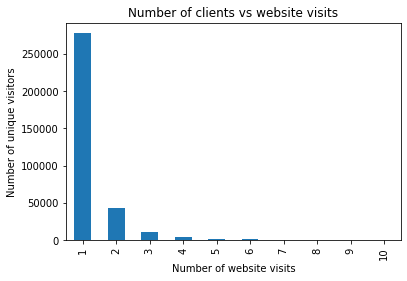

In [122]:
# plot of number of visits per clientID 
grouped_df_per_clientID.rename(columns={0:'counts'}, inplace = True)

print(grouped_df_per_clientID[grouped_df_per_clientID['counts'] <= 10]['counts'].value_counts())
grouped_df_per_clientID[grouped_df_per_clientID['counts'] <= 10]['counts'].value_counts().plot(kind = 'bar')
plt.xlabel('Number of website visits')
plt.ylabel('Number of unique visitors')
plt.title('Number of clients vs website visits')

Are transactions done by a first-time or an "old" visitor to the website? - by literature, it should be done by "old" visitors 

Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

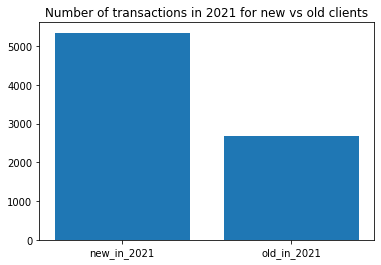

In [123]:
# new/old vs transactions 
df_new_old_client = df_original.groupby('general_type_of_client')['Transactions'].sum()
df_new_old_client = df_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_new_old_client['general_type_of_client'], df_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

In [ ]:
# df grouped per client ID 
grouped_df_per_clientID = df_giving_tuesday[['clientID']].groupby('clientID').value_counts()
grouped_df_per_clientID = grouped_df_per_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
grouped_df_per_clientID['one_vs_more_times_visitor'] = np.where(grouped_df_per_clientID > 1, "more_times", "once")
# plot of new vs old visitors in 2021 
print(grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts())
grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts().plot(kind = 'bar')
plt.title('Visitors: once vs more frequent visitor in 2021, results on GivingTuesday')

#### Visits and transactions per channel group 

Text(0.5, 1.0, 'Number of clientIDs per channel group')

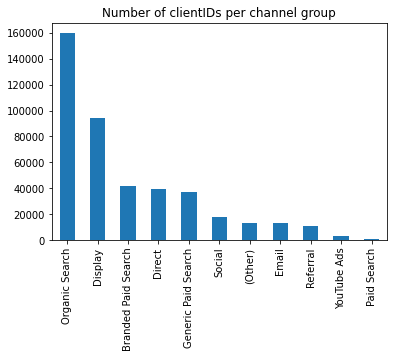

In [135]:
# visits
df_eda['Channel group'].value_counts().plot(kind = 'bar')
plt.title('Number of clientIDs per channel group')

In [ ]:
# transactions 


In [137]:
# df grouped per client ID 
grouped_df_per_clientID = df_eda[['clientID', 'Transactions']].groupby('clientID').value_counts()
grouped_df_per_clientID = grouped_df_per_clientID.to_frame().reset_index()
grouped_df_per_clientID['Transactions'].sum()

7572

### Visit patterns along the year 

Focus - feature `clientID`

* The number of total client IDs in 2021 = 471.532 for the available data, from 323.353 different users. That number of different users may not be 100% real because 
    - Same user with different device has different client ID 
    - Users from iOS get a new client ID every 7 days 

Check plots of
* new vs old visitors 
* number of total visits per client ID 
* number of visits per day for the whole year 

In [40]:
# df grouped per client ID 
grouped_df_per_clientID = df_eda[['clientID']].groupby('clientID').value_counts()
grouped_df_per_clientID = grouped_df_per_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
grouped_df_per_clientID['one_vs_more_times_visitor'] = np.where(grouped_df_per_clientID > 1, "more_times", "once")
grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts()

#### Number of clientIDs per channel/source/medium

In [ ]:
# df_eda['User type'].value_counts()
channel_groups = ['Organic Search', 'Display', 'Branded Paid Search', 'Direct', 'Generic Paid Search', 'Referral', 'Social', 'Email', '(Other)', 'YouTube Ads', 'Paid Search']
for channel in channel_groups: 
    print('Results for channel group = ', channel)
    channel_df = df_eda[df_eda['Channel group'] == channel]
    # plot medium and source in 2 subplots
    fig = plt.figure() 
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    channel_df['Medium'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Medium levels')
    plt.subplot(1, 2, 2) # index 2
    channel_df['Source'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Source levels')
    # minimize overlap 
    plt.tight_layout()
    plt.show()
# df_eda['Source'].value_counts().plot(kind = 'bar')
# plt.title('Source levels')
df_eda['Medium'].value_counts().plot(kind = 'bar')
plt.title('Medium levels')

#### Evtl. TODO - repeat for other features

#### Check number of (total) client IDs per day and channel 

Check if transactions come from "new" (i.e. first seen in 2021) or "old" donors

Compare those results with feature "User type"

In [ ]:
df_user_type = df_extended.groupby('User type')['Transactions'].sum()
df_user_type

<class 'pandas.core.series.Series'>
Index: 2 entries, New Visitor to Returning Visitor
Series name: Transactions
Non-Null Count  Dtype
--------------  -----
2 non-null      int64
dtypes: int64(1)
memory usage: 32.0+ bytes


#### Check conversions per channel  

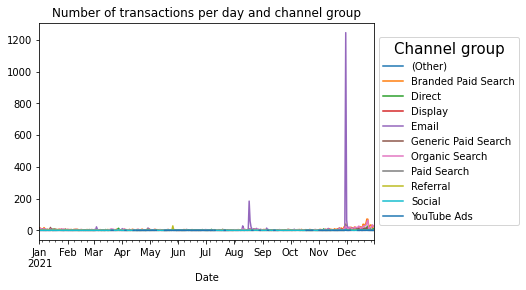

In [ ]:
# function to create features of interest 
def grouped_df (df, feats_to_select, feat_to_group_by, feat_to_order_table_by):
    # create features of interest 
    df_grouped = df[feats_to_select].groupby(feat_to_group_by).sum() 
    df_grouped['Transactions per user'] = df_grouped['Transactions'] / df_grouped['Users']
    df_grouped['Revenue per user'] = df_grouped['Transaction revenue'] / df_grouped['Users']
    df_grouped['Users percentage'] = df_grouped['Users'] / df_grouped['Users'].sum()
    df_grouped['Transaction revenue percentage'] = df_grouped['Transaction revenue'] / df_grouped['Transaction revenue'].sum()
    df_grouped['Transaction percentage'] = df_grouped['Transactions'] / df_grouped['Transactions'].sum()
    # reset index - to be able to use grouping feature as feature in plot 
    df_grouped = df_grouped.reset_index() 
    # order table by feature of interest 
    df_grouped = df_grouped.sort_values(feat_to_order_table_by)
    return df_grouped 

In [ ]:
feats_to_select = ['Channel group', 'Users', 'Transactions', 'Transaction revenue']
feat_to_group_by = 'Channel group'
feat_to_order_table_by = 'Transactions'
df_grouped_by_channel_general = grouped_df(df_extended, feats_to_select, feat_to_group_by, feat_to_order_table_by)
df_grouped_by_channel_general

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Users percentage,Transaction revenue percentage,Transaction percentage
7,Paid Search,1101,1,221.8535,0.000908,0.201502,0.002342,0.000187,0.000136
10,YouTube Ads,2968,2,290.5224,0.000674,0.097885,0.006313,0.000245,0.000272
0,(Other),13282,13,2668.5804,0.000979,0.200917,0.028250,0.002246,0.001768
3,Display,94122,27,3086.4050,0.000287,0.032792,0.200194,0.002598,0.003671
9,Social,18200,42,2781.6205,0.002308,0.152836,0.038711,0.002341,0.005710
8,Referral,24419,151,23318.2807,0.006184,0.954924,0.051938,0.019628,0.020530
2,Direct,41212,774,134516.7638,0.018781,3.264019,0.087656,0.113231,0.105235
5,Generic Paid Search,38336,805,83224.5154,0.020999,2.170923,0.081539,0.070055,0.109449
6,Organic Search,173244,1589,341970.5863,0.009172,1.973925,0.368484,0.287858,0.216044
1,Branded Paid Search,47765,1904,399184.5199,0.039862,8.357260,0.101594,0.336019,0.258872


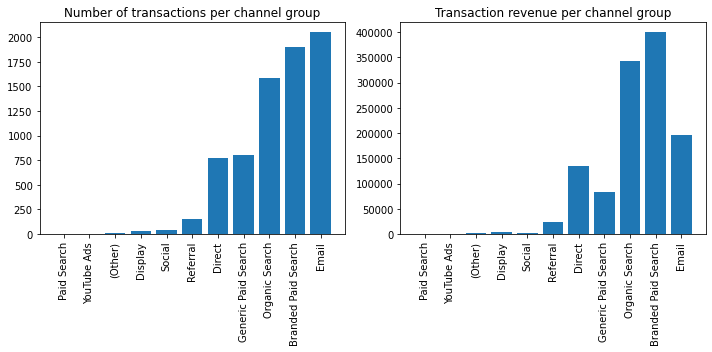

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

In [ ]:
def two_plots (df, feat1, feat2, feat3): 
    fig = plt.figure() 
    fig.set_figheight(5)
    fig.set_figwidth(10)

    plt.subplot(1, 2, 1) # row 1, col 2 index 1

    plt.bar(df[feat1], df[feat2])
    plt.xticks(rotation = 90)
    #plt.title('Number of transactions per channel group')

    plt.subplot(1, 2, 2) # index 2
    plt.bar(df[feat1], df[feat3])
    plt.xticks(rotation = 90)
    # plt.title('Transaction revenue per channel group')

    # minimize overlap 
    plt.tight_layout()

    plt.show()
    return plt 

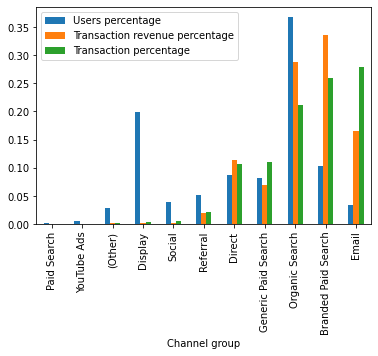

In [ ]:
# df_grouped_by_channel_general.plot(x='Channel group', y=['Transactions per user', 'Revenue per user'], grid=True)
# plotting graph
df_grouped_by_channel_general.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

#### Check conversions per channel - Focus December

In [ ]:
#feats_to_select = ['Channel group', 'Users', 'Transactions', 'Transaction revenue']
#feat_to_group_by = 'Channel group'
#feat_to_order_table_by = 'Transactions'
df_december = df_extended[df_extended['Date'] >= '2021-12-01']
df_grouped_by_channel_december = grouped_df(df_december, feats_to_select, feat_to_group_by, feat_to_order_table_by)

Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

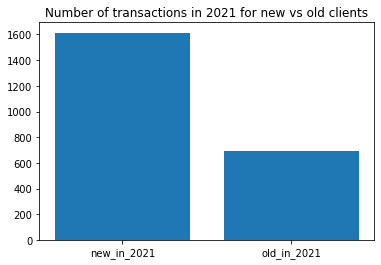

In [ ]:
# new/old vs transactions 
df_december_new_old_client = df_december.groupby('new_old_client')['Transactions'].sum()
df_december_new_old_client = df_december_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_december_new_old_client['new_old_client'], df_december_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

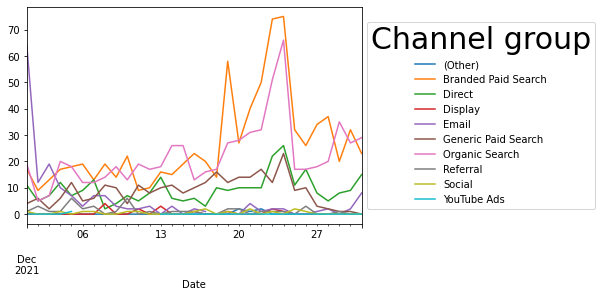

In [ ]:
df_december.groupby(['Date', 'Channel group']).sum().unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

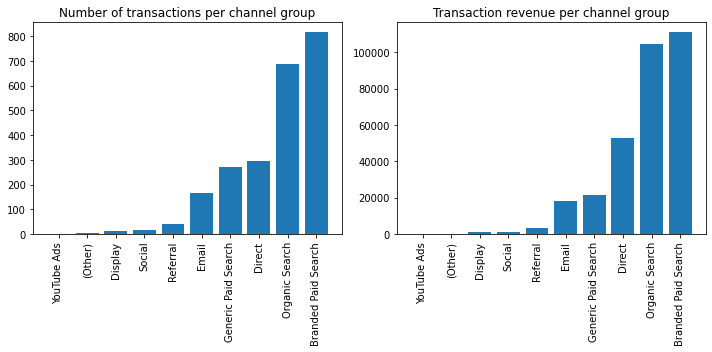

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_december['Channel group'], df_grouped_by_channel_december['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_december['Channel group'], df_grouped_by_channel_december['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

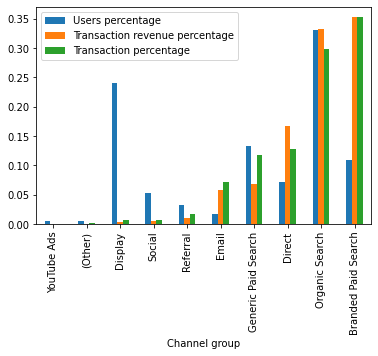

In [ ]:
df_grouped_by_channel_december.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

In [ ]:

df_grouped_by_channel_giving_tuesday = grouped_df(df_giving_tuesday, feats_to_select, feat_to_group_by, feat_to_order_table_by)
df_grouped_by_channel_giving_tuesday

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Users percentage,Transaction revenue percentage,Transaction percentage
9,YouTube Ads,8,0,0.0000,0.000000,0.000000,0.001778,0.000000,0.000000
0,(Other),43,1,1056.4451,0.023256,24.568491,0.009556,0.008288,0.000691
3,Display,112,2,121.4912,0.017857,1.084743,0.024889,0.000953,0.001382
7,Referral,125,5,316.9336,0.040000,2.535469,0.027778,0.002487,0.003455
8,Social,89,6,137.3380,0.067416,1.543124,0.019778,0.001078,0.004147
5,Generic Paid Search,331,9,422.5782,0.027190,1.276671,0.073556,0.003315,0.006220
6,Organic Search,866,29,2599.9116,0.033487,3.002207,0.192444,0.020398,0.020041
2,Direct,291,39,3444.0117,0.134021,11.835092,0.064667,0.027020,0.026952
1,Branded Paid Search,371,44,5863.2709,0.118598,15.803965,0.082444,0.046001,0.030408
4,Email,2264,1312,113497.4233,0.579505,50.131371,0.503111,0.890459,0.906704


Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

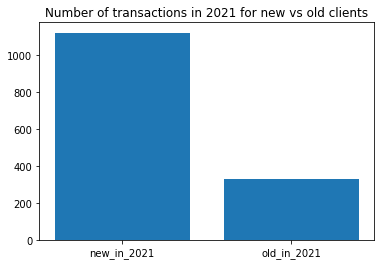

In [ ]:
# new/old vs transactions 
df_giving_tuesday_new_old_client = df_giving_tuesday.groupby('new_old_client')['Transactions'].sum()
df_giving_tuesday_new_old_client = df_giving_tuesday_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_giving_tuesday_new_old_client['new_old_client'], df_giving_tuesday_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

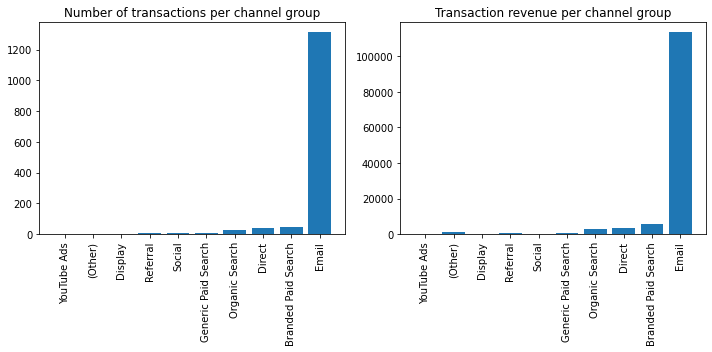

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_giving_tuesday['Channel group'], df_grouped_by_channel_giving_tuesday['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_giving_tuesday['Channel group'], df_grouped_by_channel_giving_tuesday['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

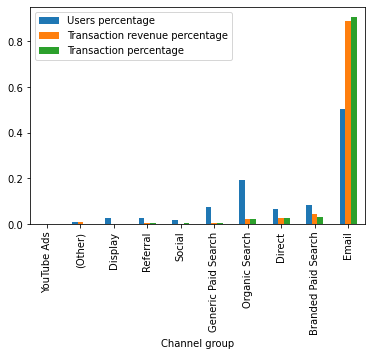

In [ ]:
df_grouped_by_channel_giving_tuesday.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

#### Results without #GivingTuesday (2021-11-30)

* Drop #GivingTuesday day - to make analysis easier 
* We still observe 2 peaks in the number of daily transactions
* Even without #GivingTuesday, data peaks seem to correspond to Email marketing. An increase in transactions from Organic Search and Branded Paid Search seems to exist by the end of the year as well


In [ ]:
df_no_giving_tuesday = df_extended
df_no_giving_tuesday = df_no_giving_tuesday[df_no_giving_tuesday['Date'] != '2021-11-30']
df_no_giving_tuesday_with_transactions = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 0]
df_no_giving_tuesday_with_transactions_over1 = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 1]
avg_number_transactions_no_giving_tuesday = df_no_giving_tuesday.Transactions.sum() / 365

In [ ]:
print('Results without Transactions from #GivingTuesday: ')
print('Total number of transactions: ', df_no_giving_tuesday.Transactions.sum())
print('Avg number of transactions per day:', round(df_no_giving_tuesday.Transactions.sum()/365, 2))
print('Total number of clientIDs with transactions:', len(df_no_giving_tuesday_with_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_no_giving_tuesday_with_transactions_over1.clientID.value_counts()))

Results without Transactions from #GivingTuesday: 
Total number of transactions:  6278
Avg number of transactions per day: 17.2
Total number of clientIDs with transactions: 5370
Total number of clientIDs with more than 1 transaction: 226


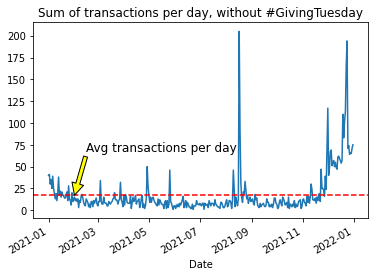

In [ ]:
df_channel_no_giving_tuesday = df_no_giving_tuesday[['Date', 'Users', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_not_giving_tuesday_grouped_by_channel = df_channel_no_giving_tuesday.groupby(['Date', 'Channel group']).sum()
# df_not_giving_tuesday_grouped_by_channel

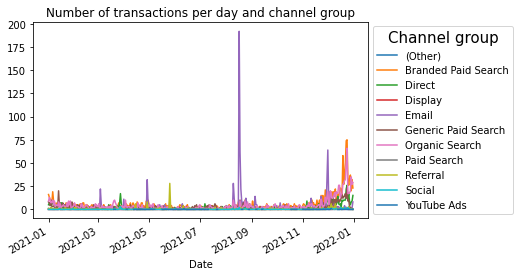

In [ ]:
df_not_giving_tuesday_grouped_by_channel.unstack()['Transactions'].plot()
plt.title('Number of transactions per day and channel group')
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Channel group	

* Make sure that order remains the same for all plots - to be able to compare them better
* Distribution of channel groups is different in terms of clients ID and transactions, see plots
* Interesting for this MT - check differences in conversions per channel groups

In [ ]:
df_extended['Channel group'].value_counts()
# order by number of transactions - to compare with groups of client IDs 
df_extended = df_extended.sort_values('Transactions')
df_transactions = df_extended[df_extended['Transactions'] > 0]
# set order - depending on number of channel groups, per year and for all data
# reference: client IDs 
order = ['Organic Search', 'Display', 'Branded Paid Search', 'Direct', 'Generic Paid Search', 'Referral', 'Social', 'Email','(Other)', 'YouTube Ads', 'Paid Search']

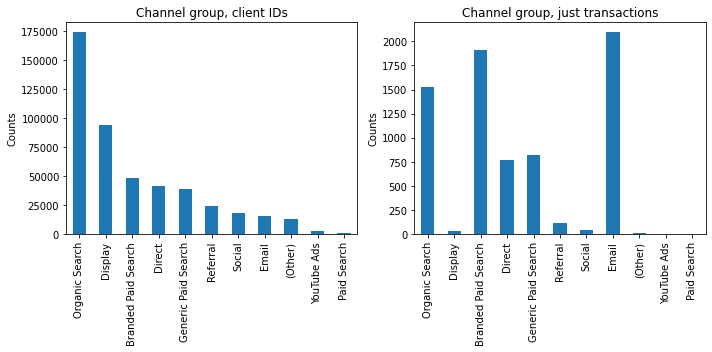

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

# plot of channel group 
plt.subplot(1, 2, 1) # row 1, col 2 index 1

df_extended['Channel group'].value_counts().reindex(order).plot(kind='bar')
# df_extended['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, client IDs')

plt.subplot(1, 2, 2) # index 2
df_transactions['Channel group'].value_counts().reindex(order).plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, just transactions')

# minimize overlap 
plt.tight_layout()

plt.show()

Check percentage of conversions per channel

In [ ]:
tab = pd.crosstab(index=df_extended['Channel group'], columns='perc')
tab/tab.sum() * 100

col_0,perc
Channel group,
(Other),2.816776
Branded Paid Search,10.231543
Direct,8.768652
Display,19.964287
Email,3.327452
Generic Paid Search,8.180145
Organic Search,36.797715
Paid Search,0.233494
Referral,5.189043


In [ ]:
pd.crosstab(index = df_extended['Channel group'], columns = df_extended['Transactions'])

Transactions,0,1,2,3,4,5,6,7,8,16,17,22
Channel group,,,,,,,,,,,,
(Other),13270,11,1,0,0,0,0,0,0,0,0,0
Branded Paid Search,46338,1836,59,8,1,1,0,0,1,1,0,0
Direct,40579,731,28,6,1,0,1,0,1,0,0,0
Display,94111,27,0,0,0,0,0,0,0,0,0,0
Email,13598,2055,31,3,1,1,0,0,0,0,1,0
Generic Paid Search,37751,792,27,2,0,0,0,0,0,0,0,0
Organic Search,171982,1460,53,10,2,2,3,1,0,0,0,0
Paid Search,1100,1,0,0,0,0,0,0,0,0,0,0
Referral,24353,100,9,1,2,1,1,0,0,0,0,1



## TODO - descriptive analysis of transaction yes/no vs other features 

#### Focus: #GivingTuesday (2021-11-30)

In previous plots we have seen that a peak exists in number of (unique) clients IDs, and specially on number of transactions. We therefore would like to check: 

* What is the "normal" ratio of transactions/client IDs, and what is the ratio on #GivingTuesday 

* What is the number of new client IDs (i.e. client IDs that did not appear in the dataset before that day, for the whole 2021)

* Transactions coming from new vs repeated client IDs 

* Proportion of source channels on #GivingTuesday vs rest of year 

# Part II. Attribution Modelling 

First tests 

## Data pre-processing 

* We need to create a table that contains the path (order) for users that have interacted with different channels along the year 2021. 
* As we can observe, some entry errors probably exist - with very big path orders (which probably correspond to the same clientID)
* From the original ~ 350.000 unique clientIDS, 74.759 appear more than once in the dataset. We have to take into account that we are just checking 1 year timeframe - in other words, (potential) donors may have checked the webpage before 01.01.2021. That information should be contained in feature "user type", but Im not sure it I will do something with it

Example based on https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling/notebook

In [ ]:
df_model = df_extended[['clientID', 'Date', 'Channel group', 'Operating system', 'Transactions', 'Transaction revenue']] # to work with this one 

In [ ]:
# create path order per clientID 
df_model['path_order'] = df_model.sort_values(['Date']).groupby(['clientID']).cumcount() + 1
df_model.head()


C:\Users\carol\AppData\Local\Temp\ipykernel_2644\3574608967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['path_order'] = df_model.sort_values(['Date']).groupby(['clientID']).cumcount() + 1


,clientID,Date,Channel group,Operating system,Transactions,Transaction revenue,path_order
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,Direct,Android,0,0.0,1
313124,1344108479.1621258077,2021-05-17,Organic Search,Android,0,0.0,1
313123,1344086711.1625086569,2021-07-21,Branded Paid Search,Android,0,0.0,2
313122,1344086711.1625086569,2021-06-30,Branded Paid Search,Android,0,0.0,1
313121,1344066949.1638532068,2021-12-03,Organic Search,Windows,0,0.0,1


In [ ]:
new_old_client = df_model[['clientID', 'Date', 'path_order']]
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['new_old_client'] = (new_old_client.path_order > 1).astype('int')
new_old_client

,clientID,Date,path_order,new_old_client
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,1,0
313124,1344108479.1621258077,2021-05-17,1,0
313122,1344086711.1625086569,2021-06-30,1,0
313121,1344066949.1638532068,2021-12-03,1,0
313120,1344049345.1636546621,2021-11-10,1,0
...,...,...,...,...
3236,14119320.1640512225,2021-12-26,1,0
420310,1812287191.1627127308,2021-12-10,10,1
337533,1448371436.1639391686,2021-12-19,3,1
60095,256128991.1616606930,2021-04-29,10,1


(?) Im not sure what to do with this. Should I get rid of some of the paths? are they entry errors? or they maybe just do not affect the result? 

In [ ]:
# check number of cases of same clientID 
cases_clientID = df_model.groupby(['clientID']).size() 
cases_clientID[cases_clientID > 1]

# transform series into dataframe 
cases_clientID = cases_clientID.to_frame(name = 'counts')

# check frequency table 
pd.crosstab(index=cases_clientID['counts'], columns='count')

col_0,count
counts,
1,248594
2,48244
3,13740
4,5992
5,2521
...,...
216,1
219,1
225,1


In [ ]:
# Aggregate the channels a user interacted with into a single row 
df_paths = df_model.groupby('clientID')['Channel group'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"Channel group": "path"})

In [ ]:
# check frequency table 
df_paths.path.value_counts()

[Organic Search]                                                                                                                                                                                          93134
[Display]                                                                                                                                                                                                 48662
[Generic Paid Search]                                                                                                                                                                                     25753
[Direct]                                                                                                                                                                                                  22953
[Branded Paid Search]                                                                                                                                                   

### Heuristic Model I - last touch 

In [ ]:
# create table of last interaction with clientID, transaction and transaction revenue 
df_last_interaction = df_model.drop_duplicates('clientID', keep = 'last')[['clientID', 'Transactions', 'Transaction revenue']]
df_last_interaction.head()

,clientID,Transactions,Transaction revenue
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,0,0.0
2,883.1608633267,0,0.0
3,1872.1612460548,0,0.0
4,12568.1632331399,0,0.0
6,24938.1636718708,0,0.0


In [80]:
# merge table with dataframe of users path 
df_paths = pd.merge(df_paths, df_last_interaction, how = 'left', on = 'clientID')
df_paths.head()

,clientID,path,Transactions,Transaction revenue
0,1000005671.1568444004,[Display],0,0.0
1,1000006728.1622927843,[Direct],0,0.0
2,1000020259.1556972396,[Referral],0,0.0
3,1000023369.1635190743,[Referral],0,0.0
4,1000024791.1630470945,[Branded Paid Search],0,0.0


In 2020, the date with highest number of transactions of the year is 01.12.2020. As a reminder, that date was 30.11 in 2021. 

**That correspond to #givingTuesday 2020 (01.12) and 2021 (30.11)** 

TODO 
* Figure out if we should get rid of information/transactions on giving Tuesday - or just study the behavior on that specific day vs rest of days 
* Figure out if some other special marketing campaigns exist during the year and try to consider if they may have an effect on the analysis 
* Consider if substituting number of transactions in giving tuesday with value of second peak makes any sense 